<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/Facial_Emotion_detection_using_MLP_CNN_CNNBN_ResNet(RAF_DB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports and Augmentation**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**FER2013 Custom Dataset Loader**

In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, usage='Training', transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(self.data.iloc[idx]['pixels'].split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = Image.fromarray(image).convert("L")
        label = int(self.data.iloc[idx]['emotion'])
        if self.transform:
            image = self.transform(image)
        return image, label


**Model 1: MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        # Corrected input size for the first linear layer (1*48*48 = 2304)
        self.fc1 = nn.Linear(48*48, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        # Corrected output size for the last linear layer (7 classes)
        self.fc5 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

**Model 2: CNN**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 10 * 10, 128), # Corrected input size to 6400
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

**Model 3: CNN + BatchNorm**

In [ ]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),               # -> [32, 46, 46]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                   # -> [32, 23, 23]

            nn.Conv2d(32, 64, 3),              # -> [64, 21, 21]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                    # -> [64, 10, 10]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 10 * 10, 128),      # ✅ Update shape here: 6400
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)  # Uncomment this line to debug shape
        return self.fc_layers(x)


**Model 4: Transfer Learning (ResNet18)**

In [ ]:
class ResNetTransfer(nn.Module):
    def __init__(self):
        super(ResNetTransfer, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = base_model.fc.in_features
        base_model.fc = nn.Linear(num_features, 7)
        self.model = base_model

    def forward(self, x):
        return self.model(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = MLP().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


**Training and Validation Loop**

In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset Load and Train**

In [ ]:
import os
import cv2
import csv
from tqdm import tqdm

def rafdb_to_pixel_csv(image_root, output_csv, usage="Training"):
    """
    Convert RAF-DB images (in folders) to FER2013-style pixel CSV.

    Args:
        image_root: path to folder (e.g., 'RAF-DB/train' or 'RAF-DB/test')
        output_csv: where to save CSV file (e.g., 'rafdb_train.csv')
        usage: 'Training', 'PublicTest', or 'PrivateTest'
    """
    # Mapping emotion names to FER2013 labels (adjust if your labels are different)
    emotion_mapping = {
        'Angry': 0,
        'Disgust': 1,
        'Fear': 2,
        'Happy': 3,
        'Sad': 4,
        'Surprise': 5,
        'Neutral': 6
    }

    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["emotion", "pixels", "Usage"])

        for label_name in sorted(os.listdir(image_root)):
            label_path = os.path.join(image_root, label_name)
            if not os.path.isdir(label_path):
                continue

            # Get the integer label from the mapping
            label = emotion_mapping.get(label_name)
            if label is None:
                print(f"⚠️ Warning: Folder '{label_name}' not found in emotion mapping. Skipping.")
                continue

            for img_name in tqdm(os.listdir(label_path), desc=f"Class {label_name}"):
                img_path = os.path.join(label_path, img_name)
                if not img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                try:
                    # 1️⃣ Read image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # grayscale
                    img = cv2.resize(img, (48, 48))  # same as FER2013 size (48x48)

                    # 2️⃣ Flatten pixels to a single string
                    pixels = " ".join(str(p) for p in img.flatten())

                    # 3️⃣ Write to CSV
                    writer.writerow([label, pixels, usage])

                except Exception as e:
                    print(f"⚠️ Error reading {img_path}: {e}")

    print(f"\n✅ Pixel CSV saved at: {output_csv}")

In [ ]:
# Convert train set
rafdb_to_pixel_csv("/content/drive/MyDrive/FER2013/DATASET/train", "rafdb_train_pixel.csv", usage="Training")

# Convert test set
rafdb_to_pixel_csv("/content/drive/MyDrive/FER2013/DATASET/test", "rafdb_test_pixel.csv", usage="PublicTest")


Class Surprise: 100%|██████████| 1290/1290 [00:28<00:00, 45.07it/s] 



✅ Pixel CSV saved at: rafdb_train_pixel.csv


Class Surprise: 100%|██████████| 329/329 [00:08<00:00, 39.18it/s] 


✅ Pixel CSV saved at: rafdb_test_pixel.csv


In [ ]:
# Load FER2013 CSV
csv_path = 'rafdb_test_pixel.csv'  # update path if needed
df = pd.read_csv(csv_path)

In [ ]:
from google.colab import files

# Download train and test pixel CSVs
files.download("rafdb_train_pixel.csv")
files.download("rafdb_test_pixel.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_dataset = FER2013Dataset("rafdb_train_pixel.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("rafdb_test_pixel.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_1, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_1, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.48, Val Acc=0.55
Epoch 2: Train Acc=0.55, Val Acc=0.58
Epoch 3: Train Acc=0.57, Val Acc=0.59
Epoch 4: Train Acc=0.60, Val Acc=0.62
Epoch 5: Train Acc=0.61, Val Acc=0.61
Epoch 6: Train Acc=0.63, Val Acc=0.62
Epoch 7: Train Acc=0.63, Val Acc=0.63
Epoch 8: Train Acc=0.65, Val Acc=0.64
Epoch 9: Train Acc=0.66, Val Acc=0.64
Epoch 10: Train Acc=0.66, Val Acc=0.64
Epoch 11: Train Acc=0.70, Val Acc=0.66
Epoch 12: Train Acc=0.71, Val Acc=0.67
Epoch 13: Train Acc=0.71, Val Acc=0.67
Epoch 14: Train Acc=0.72, Val Acc=0.66
Epoch 15: Train Acc=0.73, Val Acc=0.67
Epoch 16: Train Acc=0.73, Val Acc=0.66
Epoch 17: Train Acc=0.73, Val Acc=0.67
Epoch 18: Train Acc=0.74, Val Acc=0.67
Epoch 19: Train Acc=0.74, Val Acc=0.66
Epoch 20: Train Acc=0.74, Val Acc=0.67
Epoch 21: Train Acc=0.75, Val Acc=0.67
Epoch 22: Train Acc=0.75, Val Acc=0.67
Epoch 23: Train Acc=0.76, Val Acc=0.67
Epoch 24: Train Acc=0.75, Val Acc=0.67
Epoch 25: Train Acc=0.75, Val Acc=0.67
Epoch 26: Train Acc=0.75, Val Acc=

**Plot Accuracy & Loss**

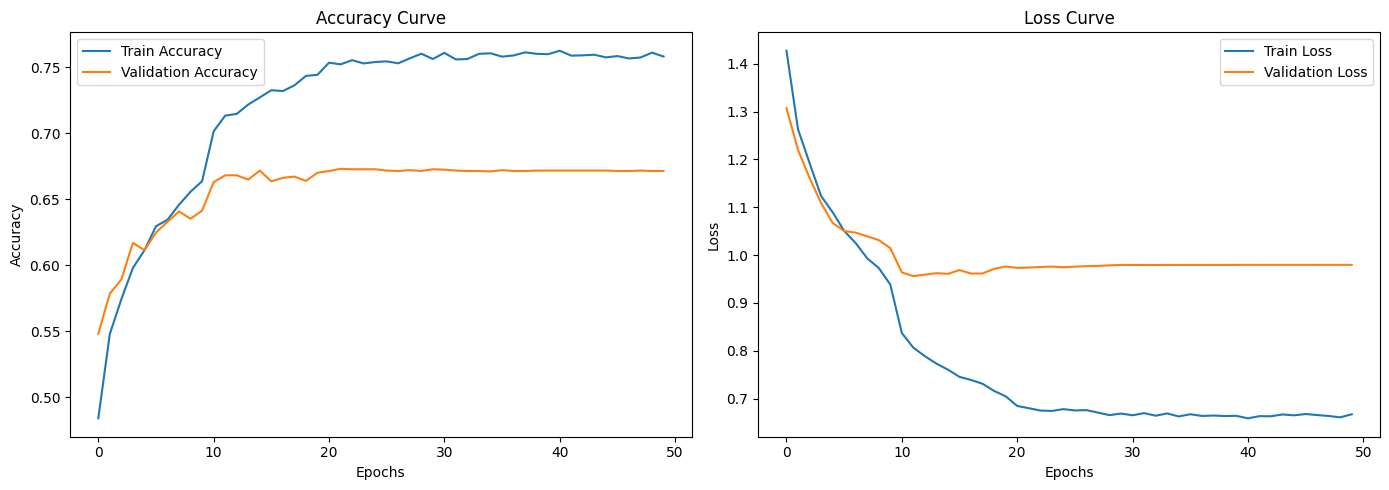

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


**Confusion Matrix & Classification Report**

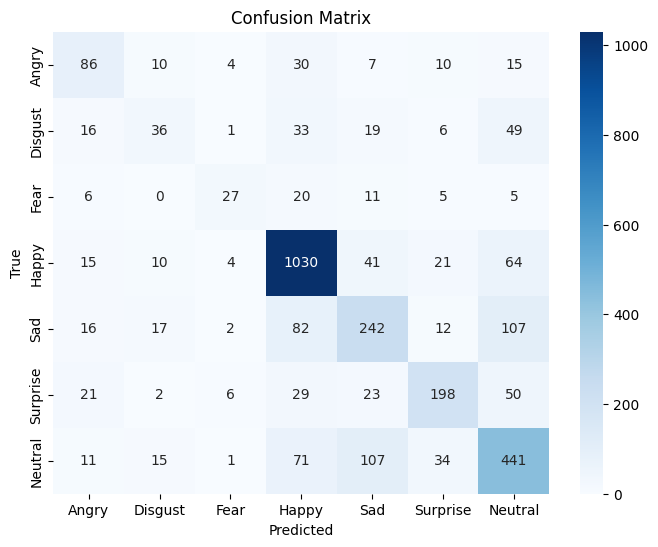

              precision    recall  f1-score   support

       Angry       0.50      0.53      0.52       162
     Disgust       0.40      0.23      0.29       160
        Fear       0.60      0.36      0.45        74
       Happy       0.80      0.87      0.83      1185
         Sad       0.54      0.51      0.52       478
    Surprise       0.69      0.60      0.64       329
     Neutral       0.60      0.65      0.63       680

    accuracy                           0.67      3068
   macro avg       0.59      0.54      0.55      3068
weighted avg       0.66      0.67      0.66      3068



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_1.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = CNN().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/ckextended.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_2, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_2, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
# Make predictions
all_preds = []
all_labels = []

model_2.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = CNN_BN().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train_dataset = FER2013Dataset("rafdb_train_pixel.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("rafdb_test_pixel.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_3, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_3, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.55, Val Acc=0.62
Epoch 2: Train Acc=0.65, Val Acc=0.68
Epoch 3: Train Acc=0.69, Val Acc=0.69
Epoch 4: Train Acc=0.71, Val Acc=0.73
Epoch 5: Train Acc=0.73, Val Acc=0.74
Epoch 6: Train Acc=0.74, Val Acc=0.75
Epoch 7: Train Acc=0.75, Val Acc=0.75
Epoch 8: Train Acc=0.75, Val Acc=0.76
Epoch 9: Train Acc=0.77, Val Acc=0.76
Epoch 10: Train Acc=0.77, Val Acc=0.77
Epoch 11: Train Acc=0.80, Val Acc=0.78
Epoch 12: Train Acc=0.81, Val Acc=0.78
Epoch 13: Train Acc=0.82, Val Acc=0.78
Epoch 14: Train Acc=0.82, Val Acc=0.79
Epoch 15: Train Acc=0.82, Val Acc=0.79
Epoch 16: Train Acc=0.82, Val Acc=0.79
Epoch 17: Train Acc=0.82, Val Acc=0.79
Epoch 18: Train Acc=0.82, Val Acc=0.79
Epoch 19: Train Acc=0.82, Val Acc=0.79
Epoch 20: Train Acc=0.83, Val Acc=0.79
Epoch 21: Train Acc=0.83, Val Acc=0.79
Epoch 22: Train Acc=0.83, Val Acc=0.79
Epoch 23: Train Acc=0.84, Val Acc=0.79
Epoch 24: Train Acc=0.84, Val Acc=0.79
Epoch 25: Train Acc=0.83, Val Acc=0.79
Epoch 26: Train Acc=0.84, Val Acc=

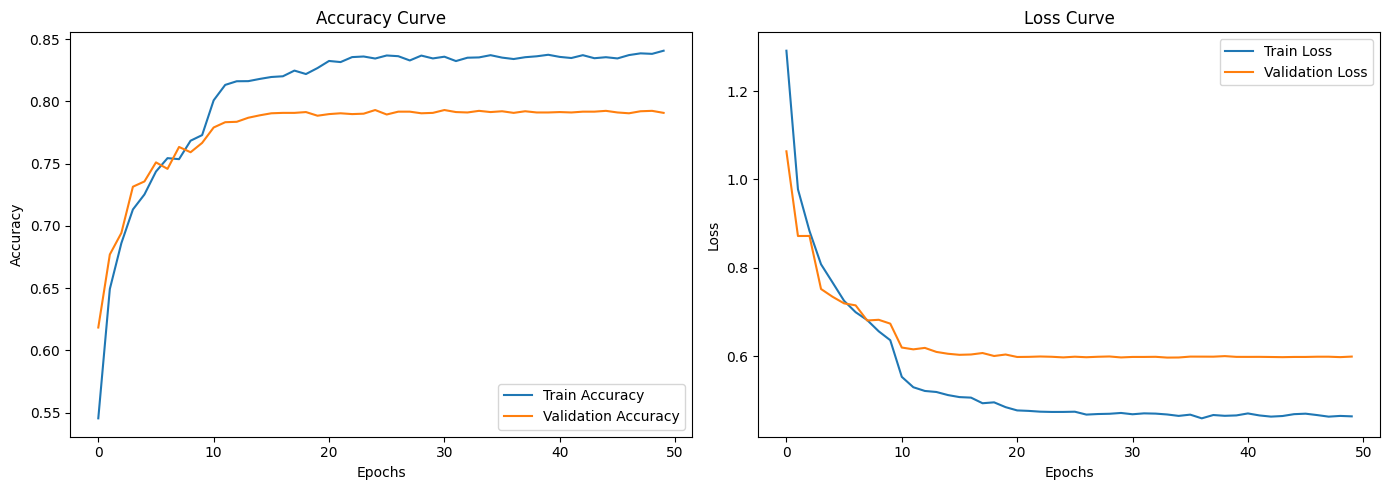

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

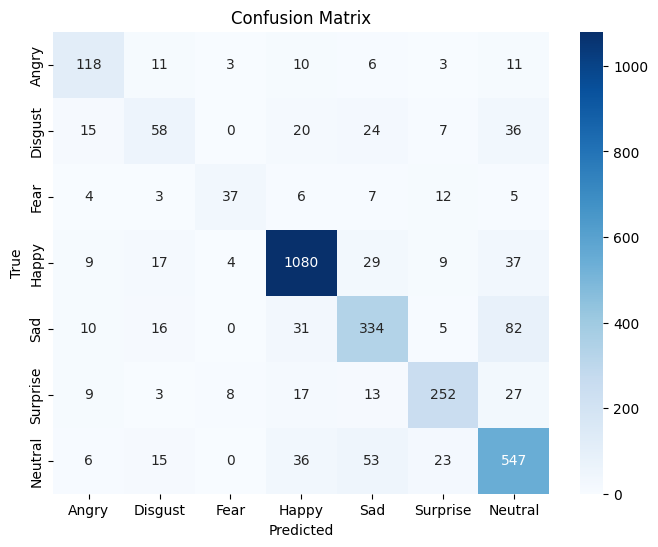

              precision    recall  f1-score   support

       Angry       0.69      0.73      0.71       162
     Disgust       0.47      0.36      0.41       160
        Fear       0.71      0.50      0.59        74
       Happy       0.90      0.91      0.91      1185
         Sad       0.72      0.70      0.71       478
    Surprise       0.81      0.77      0.79       329
     Neutral       0.73      0.80      0.77       680

    accuracy                           0.79      3068
   macro avg       0.72      0.68      0.70      3068
weighted avg       0.79      0.79      0.79      3068



In [ ]:
# Make predictions
all_preds = []
all_labels = []

model_3.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4 = ResNetTransfer().to(device)  # পরিবর্তন করুন অন্য মডেল অনুযায়ী: MLP(), CNN(), ResNetTransfer()

optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/rafdb_train_pixel.csv", usage='Training', transform=transform_train)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/rafdb_test_pixel.csv", usage='PublicTest', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(50):
    train_loss, train_acc = train(model_4, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_4, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.51, Val Acc=0.52
Epoch 2: Train Acc=0.62, Val Acc=0.65
Epoch 3: Train Acc=0.66, Val Acc=0.65
Epoch 4: Train Acc=0.69, Val Acc=0.72
Epoch 5: Train Acc=0.71, Val Acc=0.72
Epoch 6: Train Acc=0.73, Val Acc=0.73
Epoch 7: Train Acc=0.74, Val Acc=0.73
Epoch 8: Train Acc=0.75, Val Acc=0.74
Epoch 9: Train Acc=0.78, Val Acc=0.73
Epoch 10: Train Acc=0.78, Val Acc=0.75
Epoch 11: Train Acc=0.84, Val Acc=0.79
Epoch 12: Train Acc=0.86, Val Acc=0.78
Epoch 13: Train Acc=0.86, Val Acc=0.79
Epoch 14: Train Acc=0.87, Val Acc=0.79
Epoch 15: Train Acc=0.88, Val Acc=0.79
Epoch 16: Train Acc=0.89, Val Acc=0.79
Epoch 17: Train Acc=0.90, Val Acc=0.78
Epoch 18: Train Acc=0.90, Val Acc=0.79
Epoch 19: Train Acc=0.90, Val Acc=0.79
Epoch 20: Train Acc=0.92, Val Acc=0.79
Epoch 21: Train Acc=0.92, Val Acc=0.79
Epoch 22: Train Acc=0.93, Val Acc=0.79
Epoch 23: Train Acc=0.93, Val Acc=0.79
Epoch 24: Train Acc=0.93, Val Acc=0.79
Epoch 25: Train Acc=0.93, Val Acc=0.79
Epoch 26: Train Acc=0.93, Val Acc=

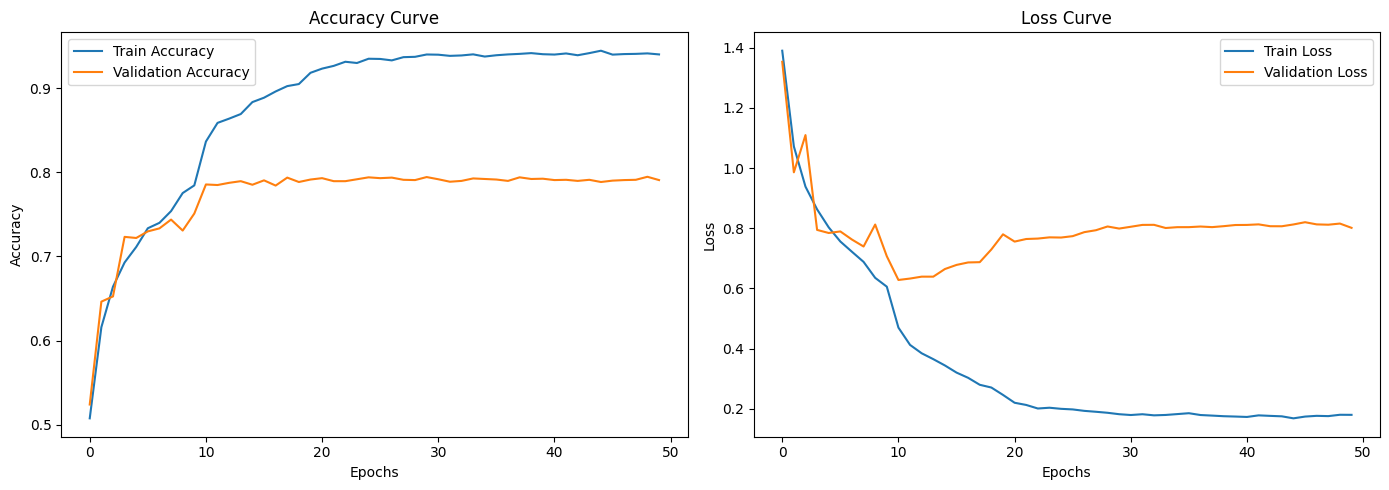

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


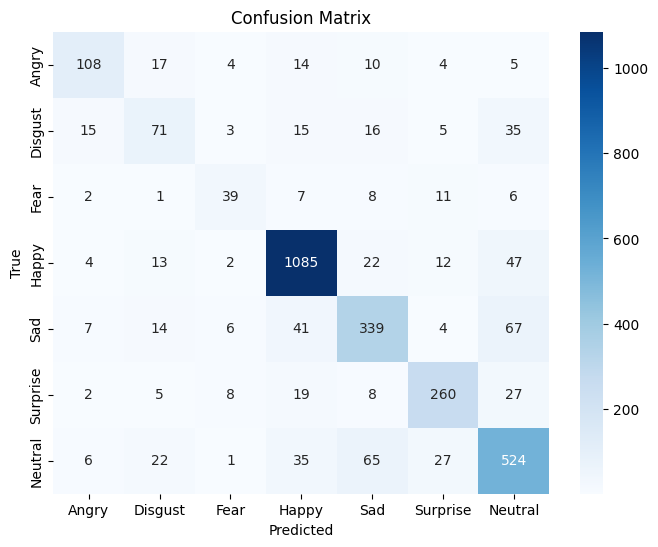

              precision    recall  f1-score   support

       Angry       0.75      0.67      0.71       162
     Disgust       0.50      0.44      0.47       160
        Fear       0.62      0.53      0.57        74
       Happy       0.89      0.92      0.90      1185
         Sad       0.72      0.71      0.72       478
    Surprise       0.80      0.79      0.80       329
     Neutral       0.74      0.77      0.75       680

    accuracy                           0.79      3068
   macro avg       0.72      0.69      0.70      3068
weighted avg       0.79      0.79      0.79      3068



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_4.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_4(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

**Model-5:ConvNeXt**

In [ ]:
import torch
import torch.nn as nn
import timm  # pip install timm

# ---------------------------------------------
# ✅ Pretrained ConvNeXt for CK+ (7 classes)
# ---------------------------------------------
class ConvNeXt_CK_Preload(nn.Module):
    def __init__(self, num_classes=7):
        super(ConvNeXt_CK_Preload, self).__init__()

        # 1️⃣ Load pretrained ConvNeXt (tiny variant recommended)
        self.backbone = timm.create_model(
            "convnext_tiny.fb_in22k_ft_in1k",  # You can also try: convnext_small.in12k_ft_in1k
            pretrained=True,
            in_chans=3  # pretrained weights expect RGB images
        )

        # 2️⃣ Replace classifier head
        in_features = self.backbone.head.fc.in_features
        self.backbone.head.fc = nn.Identity()  # remove default head

        # 3️⃣ Add custom classification head for CK+
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 1 → 3 channels
    transforms.Resize((224, 224)),                # ConvNeXt input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Ensure 3 channels for validation as well
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
import torch.optim as optim

model_5 = ConvNeXt_CK_Preload(num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_5.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
train_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/rafdb_train_pixel.csv", usage='Training', transform=train_transforms)
val_dataset = FER2013Dataset("/content/drive/MyDrive/FER2013/rafdb_test_pixel.csv", usage='PublicTest', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(25):
    train_loss, train_acc = train(model_5, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_5, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

Epoch 1: Train Acc=0.78, Val Acc=0.81
Epoch 2: Train Acc=0.83, Val Acc=0.82
Epoch 3: Train Acc=0.88, Val Acc=0.84
Epoch 4: Train Acc=0.92, Val Acc=0.84
Epoch 5: Train Acc=0.96, Val Acc=0.84
Epoch 6: Train Acc=0.98, Val Acc=0.86
Epoch 7: Train Acc=0.99, Val Acc=0.86
Epoch 8: Train Acc=1.00, Val Acc=0.86
Epoch 9: Train Acc=1.00, Val Acc=0.86
Epoch 10: Train Acc=1.00, Val Acc=0.86
Epoch 11: Train Acc=1.00, Val Acc=0.86
Epoch 12: Train Acc=1.00, Val Acc=0.86
Epoch 13: Train Acc=1.00, Val Acc=0.86
Epoch 14: Train Acc=1.00, Val Acc=0.85
Epoch 15: Train Acc=0.99, Val Acc=0.84
Epoch 16: Train Acc=0.97, Val Acc=0.84
Epoch 17: Train Acc=0.98, Val Acc=0.84
Epoch 18: Train Acc=0.97, Val Acc=0.84
Epoch 19: Train Acc=0.97, Val Acc=0.83
Epoch 20: Train Acc=0.98, Val Acc=0.83
Epoch 21: Train Acc=0.98, Val Acc=0.82
Epoch 22: Train Acc=0.99, Val Acc=0.83
Epoch 23: Train Acc=0.99, Val Acc=0.84
Epoch 24: Train Acc=0.99, Val Acc=0.84
Epoch 25: Train Acc=1.00, Val Acc=0.86


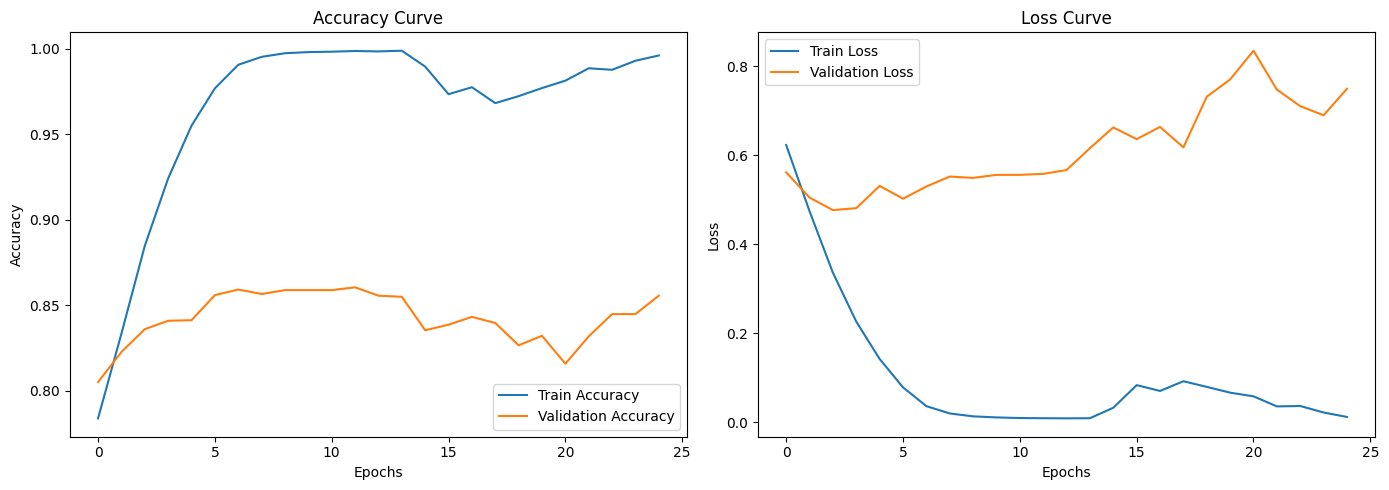

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_5.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_5(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

**Model-5:Efficenetv2**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)


    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean(dim=(2, 3))
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(b, c, 1, 1)
        return x * y


class EfficientS_SE(nn.Module):
    def __init__(self, num_classes=7, dropout=0.3):
        super().__init__()
        weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1 # Pretrained weights
        backbone = efficientnet_v2_s(weights=weights)
        self.features = nn.Sequential(*list(backbone.features.children()))
        in_features = backbone.classifier[1].in_features
        self.se = SEBlock(in_features, reduction=16)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features, num_classes)


    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.pool(x).flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import torch.optim as optim

model_6 = EfficientS_SE(num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_6.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_6.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 218MB/s]


In [ ]:
train_dataset = FER2013Dataset("rafdb_train_pixel.csv", usage='Training', transform=train_transforms)
val_dataset = FER2013Dataset("rafdb_test_pixel.csv", usage='PublicTest', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(20):
    train_loss, train_acc = train(model_6, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model_6, val_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Make predictions
all_preds = []
all_labels = []

model_6.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_6(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=emotion_labels))